# Computer Vision: course project - vehicle detector and counter

Submitted by: Yehonatan Arbel 308207604


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.distance import cdist #to calculate minimal euclidean distance

In [14]:
def closestNodes(cntrs1, cntrs2):
    pairs = []

    for c1 in cntrs1:
        c2 = cntrs2[cdist([c1], cntrs2).argmin()]
        pairs.append([c1,c2])
    return pairs

In [33]:
def dilatedImage(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
 
    blur = cv2.GaussianBlur(gray1, (5,5), 0)
    blur = cv2.GaussianBlur(blur, (5,5), 0)
    #blur = cv2.GaussianBlur(blur, (5,5), 0)
    
    blur2 = cv2.GaussianBlur(gray2, (5,5), 0)
    blur2 = cv2.GaussianBlur(blur2, (5,5), 0)
    #blur2 = cv2.GaussianBlur(blur2, (5,5), 0)
    
    diff = cv2.absdiff(blur, blur2)
    _, thresh = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, None, iterations = 2)
    #dilated = cv2.erode(dilated,np.ones((5,5)),iterations=1)
    
    return dilated

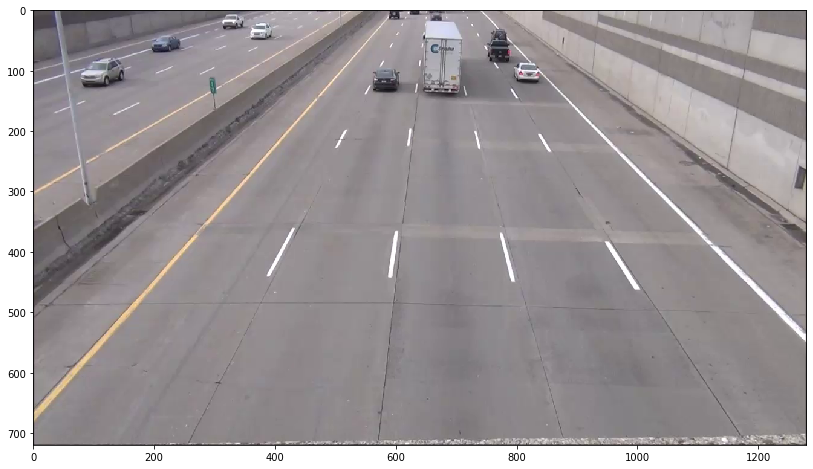

720 1280


In [34]:
cap = cv2.VideoCapture('CarsDrivingUnderBridge.mp4')

ret, frame1 = cap.read()
ret, frame2 = cap.read()
ret, frame3 = cap.read()

img1 = frame1.copy()
img2 = frame3.copy()
rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
width = img1.shape[0]
height = img1.shape[1]

plt.figure(figsize=(14,8))
plt.imshow(rgb)
plt.show()
print(width, height)

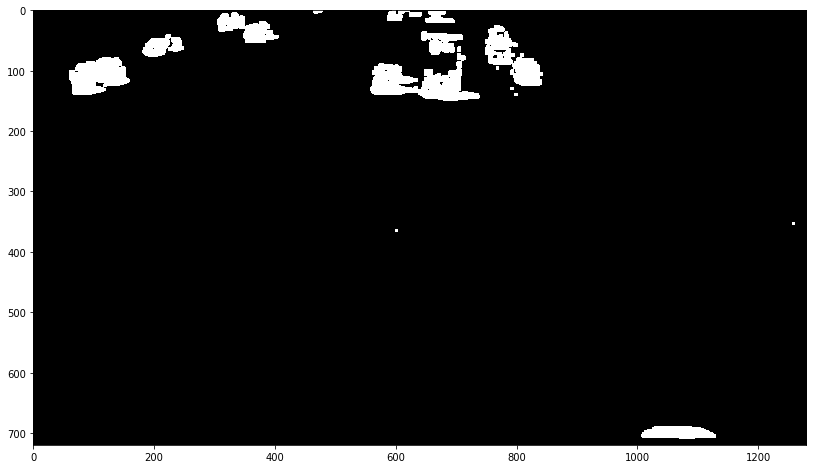

In [35]:
d2 = dilatedImage(img1,img2)
plt.figure(figsize=(14,8))
plt.imshow(d2, cmap = 'gray')
plt.show()

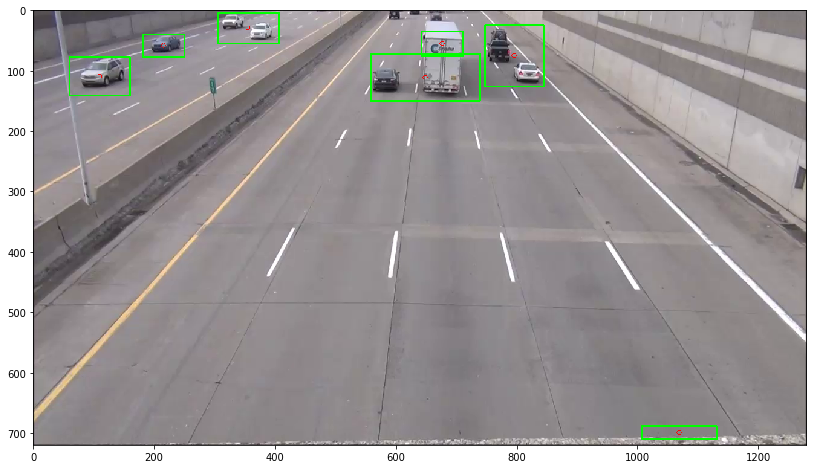

In [38]:
_,testContours,_ = cv2.findContours(d2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

for contour in testContours:
    (x,y,w,h) = cv2.boundingRect(contour)
    area1 = cv2.contourArea(contour)
    if area1 < 1000:
        continue
    (a,b) = (x+w/2, y+h/2)
        
    cv2.rectangle(rgb, (x,y), (x+w, y+h), (0,255,0), 2)
    cv2.circle(rgb, (int(a),int(b)), 4, (255,0,0), thickness=1, lineType=8, shift=0)
plt.figure(figsize=(14,8))
plt.imshow(rgb)
plt.show()

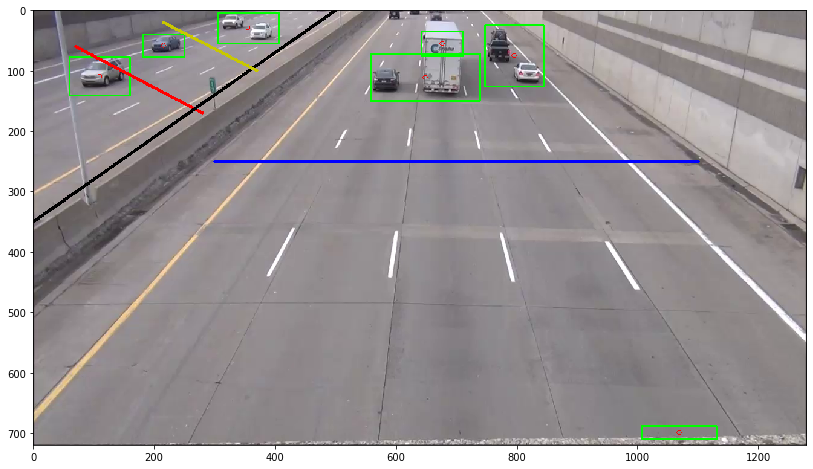

In [39]:
# blue line edges
pt1 = (300,250)
pt2 = (1100,250)

# red line edges
pt3 = (70,60)
pt4 = (280,170)

# yellow line
pt7 = (215,20)
pt8 =(370,100)

# Black line (won't be shown - only for calculations)
pt5 = (500,0)
pt6 = (0,350)

cv2.line(rgb,pt1, pt2, (0,0,255), 3) # draw blue line
cv2.line(rgb,pt3, pt4, (255,0,0), 3) # draw red line
cv2.line(rgb,pt5, pt6, (0,0,0), 3) # draw black line
cv2.line(rgb,pt7, pt8, (200,200,0), 3) # draw yellow line
plt.figure(figsize=(14,8))
plt.imshow(rgb)
plt.show()

In [40]:
# Linear equation
def incline(point1, point2):
    m = (point1[1] - point2[1]) / (point1[0] - point2[0])
    return m

def Fx(x,point1, point2):
    m = incline(point1, point2)
    y = m*x - m*point1[0] + point1[1]
    return y

In [45]:
cap = cv2.VideoCapture('CarsDrivingUnderBridge.mp4')

ret, frame1 = cap.read()
ret, frame2 = cap.read()
ret, frame3 = cap.read()
ret, frame4 = cap.read()

cntUp = 0
cntDown1 = 0
cntDown2 = 0

while ret == True:
    # finding moving objects between 1st and 2nd frames
    dilated = dilatedImage(frame1, frame3)
    _,contours,_ = cv2.findContours(dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # finding moving objects between 2nd and 3rd frames
    dilated2 = dilatedImage(frame2, frame4)
    _,contours2,_ = cv2.findContours(dilated2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    line = 250
    
    centers1 = []
    # drawing contours, finding their centers and drawing them too
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        area1 = cv2.contourArea(contour)
        if area1 < 1000:
            continue
        (a,b) = (x+w/2, y+h/2)
        centers1.append((a,b))
        
        cv2.rectangle(frame1, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.circle(frame1, (int(a),int(b)), 4, (0,0,255), thickness=1, lineType=8, shift=0)
        cv2.line(frame1, pt1, pt2, (255,0,0), 3)
        cv2.line(frame1,pt3, pt4, (0,0,255), 3)
        cv2.line(frame1,pt7, pt8, (0,200,200), 3)
        
    centers2 = []
    
    # drawing contours, finding their centers and drawing them too
    for contour2 in contours2:
        (x,y,w,h) = cv2.boundingRect(contour2)
        
        area2 = cv2.contourArea(contour2)
        if area2 < 1000:
            continue
        (a,b) = (x+w/2, y+h/2)
        centers2.append((a,b))
    
    # matching centers by euclidean distance
    pairs = closestNodes(centers1, centers2)
    
    # checking if center point crossed the drawn line
    for pair in pairs:
        (x1,y1), (x2,y2) = pair

        if y1 > line and y2 < line and x1 < 1100 and x1 >= 250:
            cntUp+=1
        else:
            if y1 < Fx(x1, pt5, pt6) and y1 < Fx(x1, pt3, pt4) and y2 < Fx(x2, pt5, pt6) and y2 > Fx(x2, pt3, pt4):
                cntDown1 += 1
            if y1 < Fx(x1, pt5, pt6) and y1 < Fx(x1, pt7, pt8) and y2 < Fx(x2, pt5, pt6) and y2 > Fx(x2, pt7, pt8):
                cntDown2 += 1           
    
    # setting counters on window
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 1
    color = (255,0,0)
    org = (50, 50)    
    thickness = 2
    cv2.putText(frame1, 'Up:{}'.format(cntUp), org, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
    if cntDown1 > cntDown2:
        cv2.putText(frame1, 'Down:{}'.format(cntDown1), (50, 100), font, fontScale, (0,0,255), thickness, cv2.LINE_AA) 
    else:
        cv2.putText(frame1, 'Down:{}'.format(cntDown2), (50, 100), font, fontScale, (0,0,255), thickness, cv2.LINE_AA) 
    
    cv2.imshow('WINDOW', frame1)
    
    frame1 = frame2
    frame2 = frame3
    frame3 = frame4
    ret, frame4 = cap.read()
    
    if (cv2.waitKey(20) & 0xff == 27): # ESC key to exit video
        break

cap.release() 
cv2.destroyAllWindows()
cv2.waitKey(1)

-1